# Lumen Data Science

PyTissue

Update or install important libraries

In [1]:
if False:
    !pip install -Uqq fastai
    !pip install -Uqq librosa

In [44]:
from fastai.data.all import *
from fastai.vision.all import *
import librosa
from IPython.display import Audio
import re
import itertools
import matplotlib.pyplot as plot
sys.path.append('../')

## Label getters

In [3]:
train_path = Path("../Dataset/Dataset/IRMAS_Training_Data")
valid_path = Path("../Dataset/Dataset/IRMAS_Validation_Data")
test_path = Path("../Dataset/Dataset/IRMAS_Test_Data")
grand_path = Path("../Dataset/Dataset")

In [4]:
path = Path("../Dataset/Dataset/IRMAS_Validation_Data/")
get_song_files = FileGetter(extensions='.wav', recurse=True)
files = get_song_files(path)
print(f"(#{len(files)})", files[:6])

(#636) [Path('../Dataset/Dataset/IRMAS_Validation_Data/(02) dont kill the whale-1.wav'), Path('../Dataset/Dataset/IRMAS_Validation_Data/(02) dont kill the whale-11.wav'), Path('../Dataset/Dataset/IRMAS_Validation_Data/(02) dont kill the whale-12.wav'), Path('../Dataset/Dataset/IRMAS_Validation_Data/(02) dont kill the whale-13.wav'), Path('../Dataset/Dataset/IRMAS_Validation_Data/(02) dont kill the whale-14.wav'), Path('../Dataset/Dataset/IRMAS_Validation_Data/(02) dont kill the whale-15.wav')]


In [5]:
def is_IRMAS_train(pat: Path):
    return str(pat).find("IRMAS_Training_Data") != -1

def is_IRMAS_valid(pat: Path):
    return str(pat).find("IRMAS_Validation_Data") != -1
    
def is_IRMAS_test(pat: Path):
    return str(pat).find("IRMAS_Test_Data") != -1

song_path = Path("../Dataset/Dataset/IRMAS_Validation_Data/(02) dont kill the whale-2.wav")
is_IRMAS_train(song_path), is_IRMAS_valid(song_path)

(False, True)

In [6]:
def get_IRMAS_train_label(pat: Path):
    r = re.search("\[[^(\[\])]+\]", pat.name)
    if r:
        return [r.group()[1:-1]]
    return []
song_path = Path("../Dataset/Dataset/IRMAS_Training_Data/cel/[cel][cla]0001__1.wav")
get_IRMAS_train_label(song_path)

['cel']

In [7]:
def get_IRMAS_valid_label(pat: Path):
    with open(os.path.splitext(str(pat))[0] + ".txt") as file:
        return file.read().split()
song_path = Path("../Dataset/Dataset/IRMAS_Validation_Data/(02) dont kill the whale-2.wav")
get_IRMAS_valid_label(song_path)

['gel', 'voi']

In [8]:
def get_label(pat: Path):
    if is_IRMAS_train(pat):
        return get_IRMAS_train_label(pat)
    return get_IRMAS_valid_label(pat)
song_path = Path("../Dataset/Dataset/IRMAS_Validation_Data/(02) dont kill the whale-2.wav")
get_label(song_path)

['gel', 'voi']

## Analyze the dataset

In [554]:
avg = np.average([len(get_label(f)) for f in get_song_files(valid_path)])

# Average accuracy when model outputs only zeros
print("All zeros model:", (11 - avg)/11)

# If model can classify one instrument with accuracy
# of ac, then total accuracy will be less than:
ac = 0.90
print("One label model:", (11 - avg + ac)/11)

# That means our model needs to have much bigger accuracy 
# than the first and we would strive for the second

All zeros model: 0.838336192109777
One label model: 0.9201543739279588


## Get items

In [10]:
n_fft = 512  # 1024
hop_length = 256  # 512
f_min = 20
f_max = 8000
sample_rate = 44100

In [11]:
def get_song(pat: Path):
    return librosa.load(pat, sr=None)[0]

In [12]:
def random_clip(clip):
    maxran = len(clip)-sample_rate*3 + 1
    if maxran <= 0: maxran = 1
    
    i = np.random.randint(maxran)
    # i=0
    clip = clip[i:i+sample_rate*3]
    
    aplen = sample_rate*3 - len(clip)
    if aplen < 0: aplen = 0
    clip = np.concatenate([clip, np.zeros(aplen, dtype="float32")])
    
    return clip

In [13]:
def get_stft(clip):
    stft = librosa.stft(clip, n_fft=n_fft, hop_length=hop_length)
    return stft

In [14]:
def get_spec(clip):
    stft = librosa.stft(clip, n_fft=n_fft, hop_length=hop_length)
    S_db = librosa.amplitude_to_db(np.abs(stft), ref=np.max)
    return S_db

In [15]:
def get_mag(clip):
    M = librosa.feature.melspectrogram(y=clip, sr=sample_rate)
    M_db = librosa.power_to_db(M, ref=np.max)
    return M_db

<Figure size 640x480 with 0 Axes>

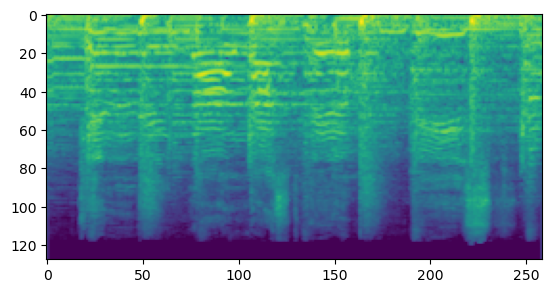

In [16]:
song_path = Path("../Dataset/Dataset/IRMAS_Validation_Data/(02) dont kill the whale-2.wav")
# spec = get_stft(random_clip(get_song(song_path)))
# plot.imshow(spec)
spec = get_spec(random_clip(get_song(song_path)))
plot.figure()
# plot.imshow(spec)
spec = get_mag(random_clip(get_song(song_path)))
plot.figure()
plot.imshow(spec)

## Metrics

In [17]:
def AccuracyMulti(tresh=0.5):
    def acc(x, y):
        return 1 - (((x > tresh).float() - y).abs()).float().mean()
    return acc
AccuracyMulti()(torch.tensor([[0.1, 0.9, 0.4], [0.2, 0.2, 0.6]]), torch.tensor([[1, 1, 0], [0, 0, 1]]))

tensor(0.8333)

## Building the model

In [531]:
get_song_tfms = [get_song, random_clip]
get_label_tfms = [get_label, MultiCategorize(), OneHotEncode()]
get_single_label_tfms = [get_label, lambda x: x[0], Categorize()]

get_spec_tfms = [get_spec, PILImage.create]
get_mag_tfms = [get_mag, PILImage.create]

In [143]:
def get_subset(x, p=0.9):
    return [x[i] for i in RandomSplitter(p)(x)[0]]

In [257]:
class AddRandomSongs(ItemTransform):
    split_idx = 0
    def __init__(self, items, augm=[], num=1):
        self.items = np.array(items)
        self.get_song_pipe = Pipeline(get_song_tfms)
        self.augm_pipe = Pipeline(augm)
        self.get_label_pipe = Pipeline(get_label_tfms)
        self.num = num
    
    def get_random_songs(self, k):
        files = np.random.choice(self.items, k)
        self.augm_pipe.split_idx = 0
        X = [self.augm_pipe([self.get_song_pipe(f)])[0] for f in files]
        Y = [self.get_label_pipe(f) for f in files]
        return X, Y
        
    def encodes(self, item):
        x, y = item
        l = np.random.poisson(self.num)
        X, Y = self.get_random_songs(l)
        X.append(x)
        Y.append(y)
        x = sum(X)
        y = TensorMultiCategory([min(i, 1) for i in sum(Y)])
        return [x, y]

In [246]:
class RandomRotate(ItemTransform):
    split_idx = 0
    def __init__(self, l=1):
        self.l = l
    def encodes(self, item):
        x = item[0]
        maxran = int(self.l*sample_rate)
        i = np.random.randint(-maxran, maxran+1)
        x = np.roll(x, i)
        return [x] + item[1:]

In [247]:
class RandomEdgeSilence(ItemTransform):
    split_idx = 0
    def __init__(self, l=1):
        self.l = l
    def encodes(self, item):
        x = item[0]
        maxran = int(sample_rate*self.l)
        i = np.random.randint(-maxran, maxran+1)
        if i < 0: x[i:] = 0
        else: x[:i] = 0
        return [x] + item[1:]

In [248]:
class RandomAmp(ItemTransform):
    split_idx = 0
    def __init__(self, rng=[0.6,2]):
        self.rng = rng
    def encodes(self, item):
        x = item[0]
        x = x * np.random.uniform(self.rng[0], self.rng[1])
        return [x] + item[1:]

In [249]:
class ToSpec(ItemTransform):
    def __init__(self, tfms):
        self.pipe = Pipeline(tfms)
    def encodes(self, item):
        x = item[0]
        return [self.pipe(x)] + item[1:]

In [250]:
class ShowSong(ItemTransform):
    split_idx = 0
    def __init__(self, k=10):
        self.cnt = 0
        self.k = k
    def encodes(self, item):
        x, y = item
        if self.cnt < self.k + 1:
            if 0 < self.cnt:
                display(y)
                display(Audio(data=x, rate=sample_rate))
            self.cnt += 1
        return item

In [251]:
def get_dataset(items, splitter=RandomSplitter()):
    splits = splitter(items)
    return Datasets(items, [get_song_tfms, get_label_tfms], splits=splits)

In [252]:
irmas_splitter = FuncSplitter(lambda x: is_IRMAS_test(x))
irmas_splitter(get_song_files(grand_path))

((#7341) [2238,2239,2240,2241,2242,2243,2244,2245,2246,2247...],
 (#2238) [0,1,2,3,4,5,6,7,8,9...])

In [532]:
items = get_song_files(grand_path)
train_dset = get_dataset(items, irmas_splitter)
augm_items = [train_dset.items[i] for i in train_dset.splits[0]]

augm = [
    RandomRotate(l=1.5),
    RandomEdgeSilence(l=1),
    RandomAmp(rng=[0.8,1.2])
]
after_augm = [
    AddRandomSongs(augm_items, augm=augm, num=2.5),
    ShowSong(3),
    ToSpec(get_spec_tfms),
    Resize((256, 156), method=ResizeMethod.Squish),
]

def get_dataloader(ds, spec_tfms=get_spec_tfms, augm=augm, after_augm=after_augm):
    after_item = augm + after_augm + [ToTensor(), IntToFloatTensor()]
    return ds.dataloaders(bs=64, after_item=after_item, shuffle=True)

TensorMultiCategory([1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])

TensorMultiCategory([1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.])

TensorMultiCategory([0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0.])

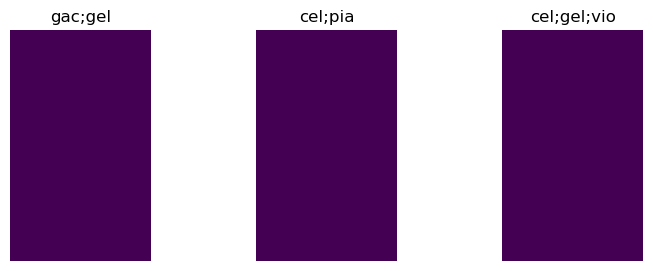

In [533]:
dls = get_dataloader(train_dset)
dls.show_batch(max_n=3)

In [534]:
print(len(dls.train.dataset))
print(len(dls.valid.dataset))
print(dls.vocab)
print(len(dls.vocab))

7341
2238
['cel', 'cla', 'flu', 'gac', 'gel', 'org', 'pia', 'sax', 'tru', 'vio', 'voi']
11


In [540]:
# learn = vision_learner(dls, lambda **args: learn_backup.model, metrics=AccuracyMulti(tresh=0.8)) 
learn = vision_learner(dls, resnet18, pretrained=True, metrics=AccuracyMulti(tresh=0.8))
# valid 
# no valid 0.878

In [541]:
learn.fine_tune(4)

In [529]:
learn_backup = learn
learn.save('SNGCLA_model')

Path('models/SNGCLA_model.pth')

In [499]:
interp = Interpretation.from_learner(learn)

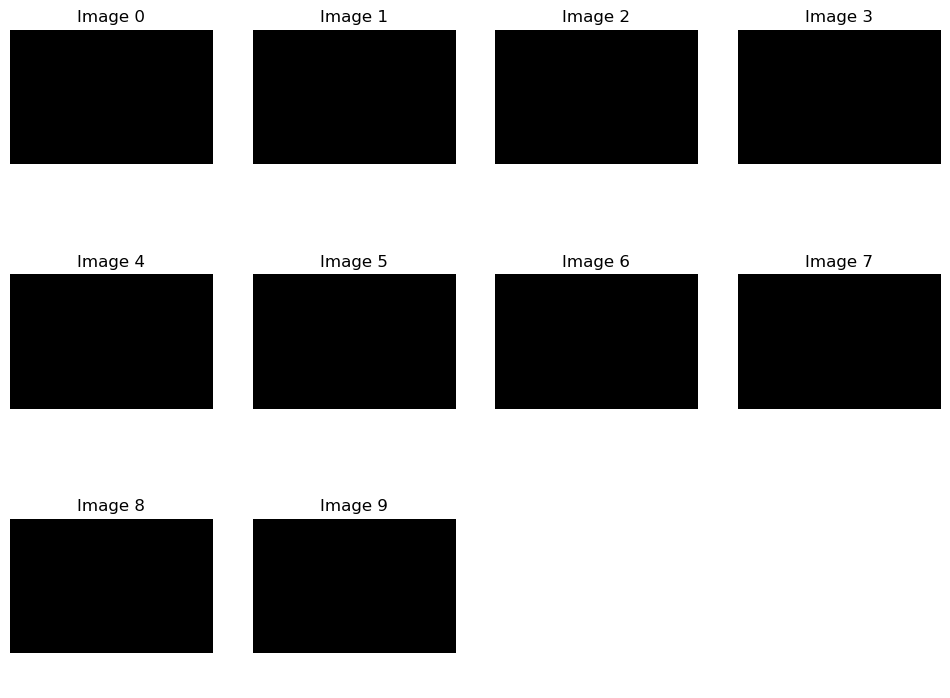

In [275]:
interp.plot_top_losses(10)

In [274]:
_, idxs = interp.top_losses(3)

for pat in np.array(dls.valid_ds.items)[idxs]:
    print(pat)
    print("Target:", get_label(pat))
    print("Preds")
    display(Audio(data=get_song(pat), rate=sample_rate))
    

../Dataset/Dataset/IRMAS_Test_Data/gyorgy ligeti- atmospheres-14.wav
Target: ['cla', 'flu', 'tru']
Preds


../Dataset/Dataset/IRMAS_Test_Data/gyorgy ligeti- atmospheres-9.wav
Target: ['cla', 'flu', 'tru']
Preds


../Dataset/Dataset/IRMAS_Test_Data/agw_-_03_-_st. elmo's fire-14.wav
Target: ['gac', 'gel', 'org', 'pia']
Preds


## Track GPU usage

In [276]:
torch.cuda.is_available(), torch.cuda.device_count(), torch.cuda.current_device()

(True, 1, 0)

In [277]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce GTX 1070'

In [278]:
import gc
def report_gpu():
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
    gc.collect()
    torch.cuda.empty_cache()

In [280]:
report_gpu()

Memory Usage:
Allocated: 0.2 GB
Cached:    0.8 GB


## Test on Validation data

In [281]:
test_items = get_song_files(test_path)
test_items = get_subset(test_items)
tdset = dls.test_dl(test_items, with_labels=True)
learn.validate(dl=tdset)

(#2) [0.3508452773094177,0.885551929473877]

In [407]:
song_path = Path("../Dataset/Dataset/IRMAS_Validation_Data/(02) dont kill the whale-1.wav")
song = random_clip(get_song(song_path))
learn.predict(song)[1]

TensorBase([False, False, False, False, False, False, False, False,  True,
            False, False])

In [471]:
song_path = Path("../Dataset/Dataset/IRMAS_Validation_Data/(02) dont kill the whale-4.wav")
song = get_song(song_path)
res = np.array([0]*len(learn.dls.vocab))
rang = range(0, len(song)-sample_rate*3, sample_rate)
for i in rang:
    short = song[i:i+sample_rate*3]
    res = res + L(learn.predict(short)[1].storage())
for i, inst in enumerate(learn.dls.vocab):
    if res[i] > len(rang) * 0.2:
        print(inst, end=" ")
print(res)

tru [0 0 0 0 0 0 0 0 9 0 0]


In [180]:
def train(arch=resnet18, tfms=get_spec_tfms, info="... get_mag_tfms", tresh=0.8):
    print("Setup:")
    print(info)
    print(arch, tfms)
    dls = get_dataloader(train_dset, tfms=tfms)
    learn = vision_learner(dls, arch, metrics=AccuracyMulti(tresh=tresh))
    learn.fine_tune(4)
    report_gpu()

In [44]:
# avg all zeros 0.844467
train(resnet18, tfms=get_spec_tfms, info="Resnet18 - with spectogram") # 0.844468
# train(resnet18, tfms=get_mag_tfms, info="Resnet18 - with magspectogram") # 0.861833
# train(squeezenet1_0, info="squeezenet1_0 - with magspectogram") # 862023
# train(densenet121, info="densenet121 - with magspectogram") # 0.844468
# train(vgg16_bn, info="vgg16_bn - with magspectogram") # 0.871576
# train(alexnet, info="alexnet - with magspectogram") # 0.858227

Setup:
Resnet18 - with spectogram
<function resnet18 at 0x7f4431b0a950> [<function get_spec at 0x7f44319d7400>, <bound method PILBase.create of <class 'fastai.vision.core.PILImage'>>]


/home/rangoiv/mambaforge/envs/fastai/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rangoiv/mambaforge/envs/fastai/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Memory Usage:
Allocated: 0.4 GB
Cached:    1.8 GB


## Gradient Accumulation

In [ ]:
# def train2(arch, accum=1, finetune=True, epochs=12, bs=64):
#     _dls = DataBlock(
#         blocks = [ImageBlock(), MultiCategoryBlock],
#         get_items = get_song_files,
#         splitter = RandomSplitter(),
#         get_x = get_magspec,
#         get_y = get_label
#     ).dataloaders(path, bs=bs)
#     cbs = GradientAccumulation(64) if accum else []
#     learn = vision_learner(_dls, arch, metrics=acc, cbs=cbs).to_fp16()
#     if finetune:
#         learn.fine_tune(epochs, 0.01)
#         # return learn.tta(dl=dls.test_dl(tst_files))
#     else:
#         learn.unfreeze()
#         learn.fit_one_cycle(epochs, 0.01)